In [147]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [148]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
 
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report

In [149]:
# Data import
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [150]:
# Descipción de datos
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [151]:
df.shape

(100000, 9)

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [153]:
df['gender'].unique()

array(['Female', 'Male', 'Other'], dtype=object)

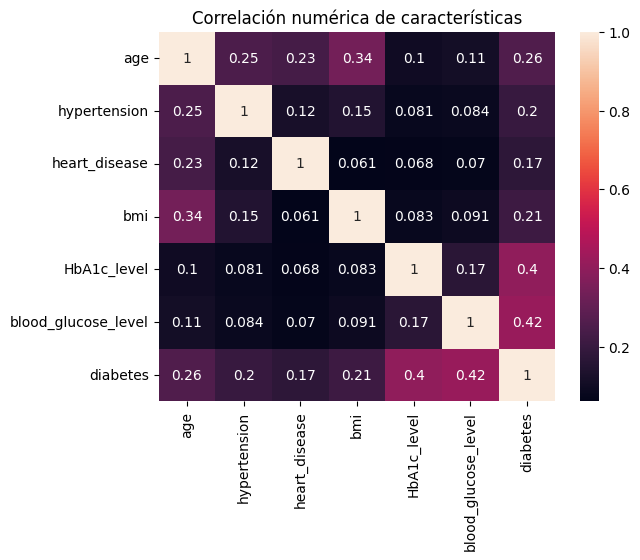

In [154]:
# Ahora vemos la correlación entre los datos

num_df = df.select_dtypes(exclude='object')
fig, ax = plt.subplots()
sns.heatmap(num_df.corr(), annot=True)
plt.title('Correlación numérica de características')
plt.show()

In [155]:
# Count the number of rows where gender is not 'Other'
count_without_other = df[df['gender'] != 'Other'].shape[0]
print(f"Number of rows without 'Other' in gender: {count_without_other}")

Number of rows without 'Other' in gender: 99982


In [156]:
# Drop rows where the 'gender' column has the value 'Other'
df = df[df['gender'] != 'Other']

In [157]:
# Convertimos genero Hombre, Mujer, a 1, 0
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [158]:
# Validamos si tenemos valore vacíos
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

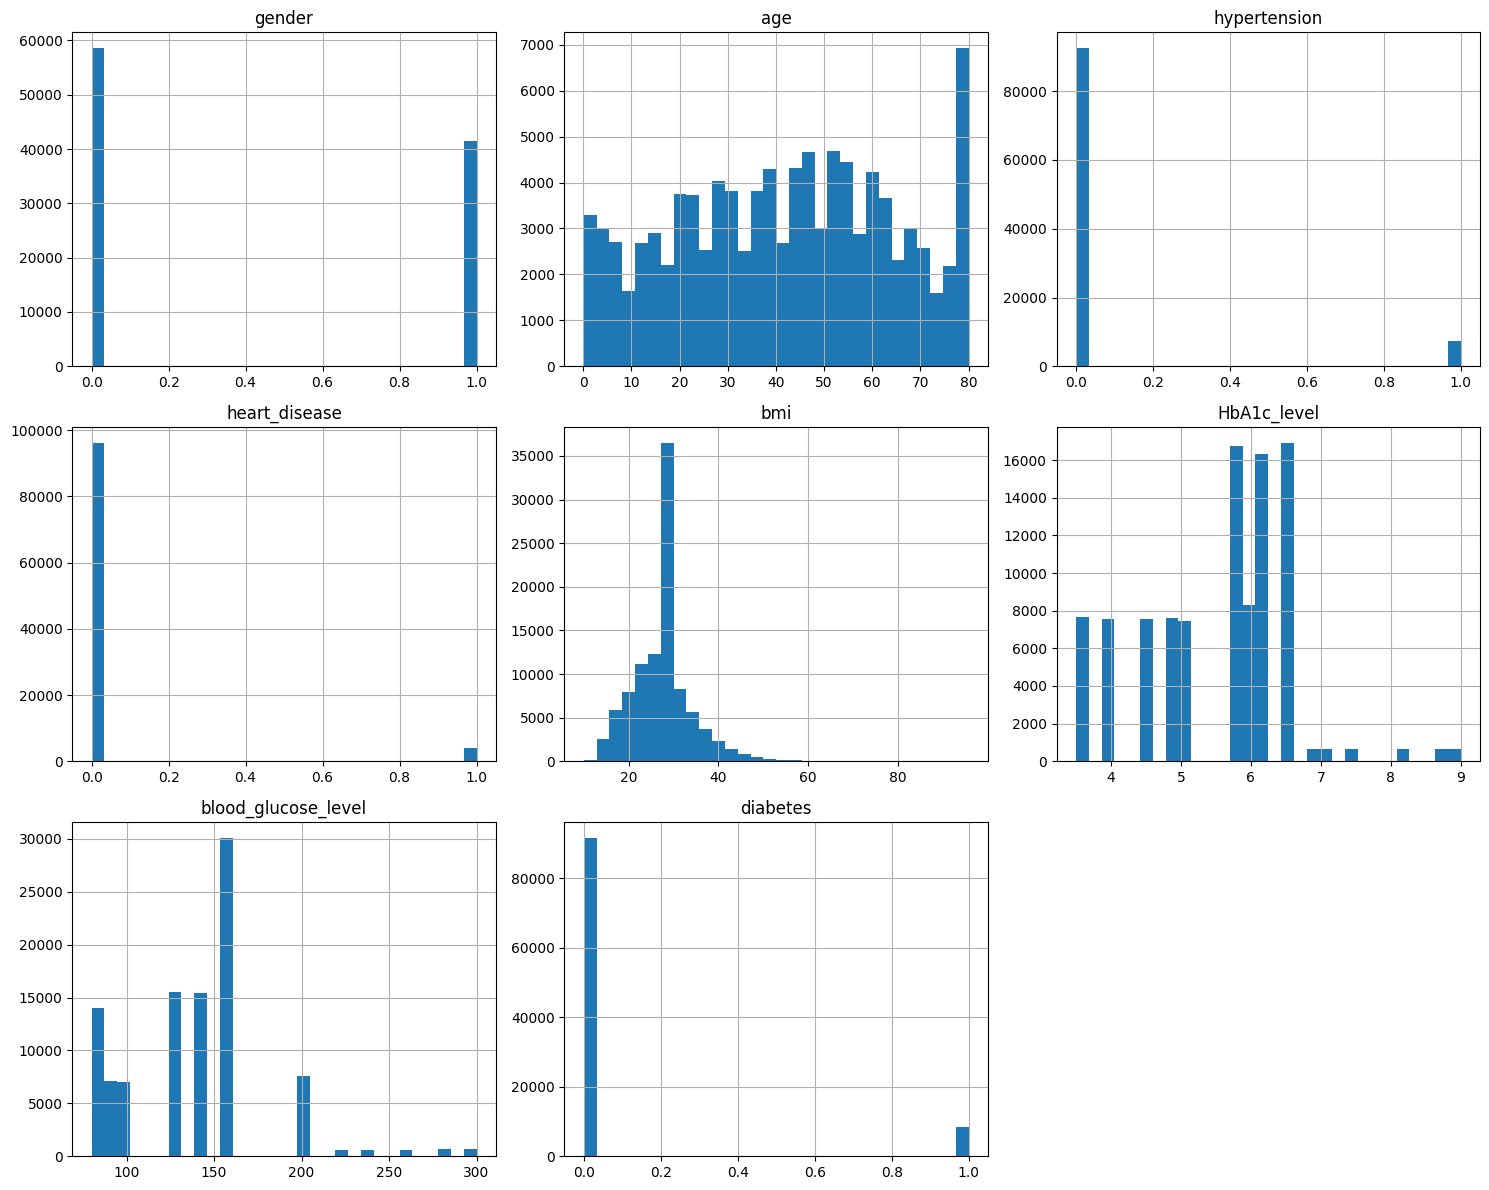

In [159]:
df.hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()

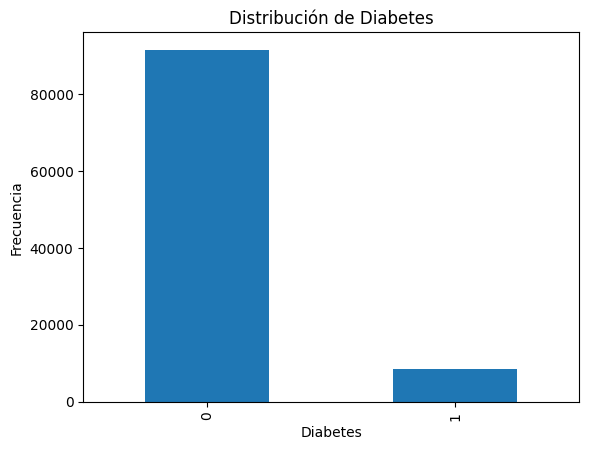

In [160]:
# Ahora vemos el conteo de nuestra variable objetivo: Diabetes

df['diabetes'].value_counts().plot(kind='bar')
plt.title('Distribución de Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Frecuencia')
plt.show()

In [161]:
df.duplicated().sum()
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [162]:
df['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [163]:
# Convertir a minúsculas y reemplazar espacios por "_"
df['smoking_history'] = df['smoking_history'].str.lower().str.replace(' ', '_')
print(df['smoking_history'].unique())

['never' 'no_info' 'current' 'former' 'ever' 'not_current']


In [164]:
df.sample(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
8952,0,63.0,0,0,ever,27.56,5.7,80,0
77046,0,40.0,0,0,former,30.79,6.0,158,0
14993,1,25.0,0,0,not_current,27.32,6.0,100,0
81330,0,57.0,0,0,not_current,22.01,5.8,140,0
94819,0,38.0,0,0,not_current,29.17,4.8,160,0
49033,0,66.0,0,0,ever,24.12,5.0,159,0
29508,0,47.0,0,0,former,21.81,5.8,80,0
57619,0,27.0,0,0,current,21.21,4.5,80,0
69283,1,62.0,1,0,no_info,26.49,4.8,160,0
4287,0,56.0,0,0,no_info,27.32,6.0,130,0


In [165]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['smoking_history']
binary_features = ['hypertension', 'heart_disease', 'gender']

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('binary', 'passthrough', binary_features)
    ]
)

# Dividir los datos
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajustar el preprocesador
preprocessor.fit(X_train)

# Transformar los datos de entrenamiento
X_train_transformed = preprocessor.transform(X_train)

# Obtener nombres de características después de la transformación
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(['smoking_history'])
feature_names = numeric_features + list(cat_feature_names) + binary_features

print("\nNombres de las características después de la transformación:")
print(feature_names)

# Convertir a DataFrame para mejor visualización
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)

print("\nPrimeras 5 filas de los datos transformados:")
print(X_train_transformed_df.head())

print("\nValores únicos en cada columna después de OneHotEncoding:")
for col in X_train_transformed_df.columns:
    if 'smoking_history' in col:
        print(f"\n{col}:")
        print(X_train_transformed_df[col].value_counts())

# Ver la distribución original vs transformada
print("\nDistribución original de smoking_history:")
print(df['smoking_history'].value_counts())


Nombres de las características después de la transformación:
['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_no_info', 'smoking_history_not_current', 'hypertension', 'heart_disease', 'gender']

Primeras 5 filas de los datos transformados:
        age       bmi  HbA1c_level  blood_glucose_level  \
0 -1.501708 -1.686520    -1.895434            -1.178336   
1  1.032334  0.175549     3.039956             0.165844   
2  0.987877  0.944633    -0.684866            -1.422733   
3  0.321024 -0.807990    -0.498625            -0.200751   
4 -0.701484 -0.791721     0.153219             0.483559   

   smoking_history_current  smoking_history_ever  smoking_history_former  \
0                      0.0                   0.0                     0.0   
1                      0.0                   0.0                     0.0   
2                      0.0                   0.0     

Feature names after transformation:
['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_no_info', 'smoking_history_not_current', 'hypertension', 'heart_disease', 'gender']

Métricas del modelo de Regresión Logística:
MAE (Error Absoluto Medio): 0.0428
R² (Coeficiente de Determinación): 0.4692

Matriz de Confusión:


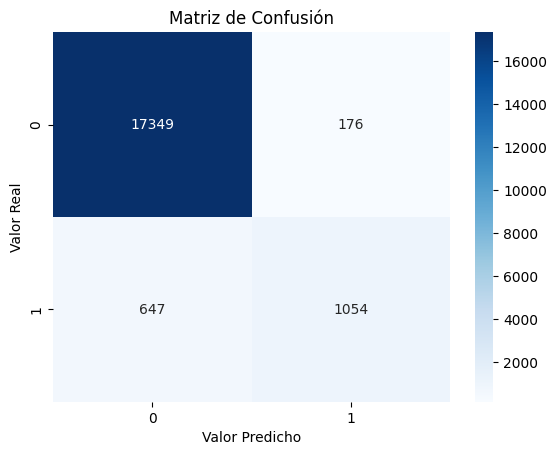


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17525
           1       0.86      0.62      0.72      1701

    accuracy                           0.96     19226
   macro avg       0.91      0.80      0.85     19226
weighted avg       0.95      0.96      0.95     19226



In [166]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
categorical_features = ['smoking_history']
binary_features = ['hypertension', 'heart_disease', 'gender']

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('binary', 'passthrough', binary_features)
    ]
)

# Create the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Split the data
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the data
pipeline.fit(X_train, y_train)

# Get feature names after transformation
cat_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['smoking_history'])
feature_names = numeric_features + list(cat_feature_names) + binary_features

print("Feature names after transformation:")
print(feature_names) 


## ---------------------------------------------

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate metrics

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMétricas del modelo de Regresión Logística:")
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")

# También podemos ver la matriz de confusión para entender mejor el rendimiento

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

### this is a divider between their work and mine -------------------------------------------------------------------------------------------------------------------------------------

In [167]:
binary_transformer = Pipeline(
    steps=[("binary_encoder", BinaryEncoder(cols=['smoking_history']))]
)

In [168]:
df_encoded = binary_transformer.fit_transform(df)

In [169]:
encoded_cols = [col for col in df_encoded.columns if 'smoking_history_' in col]

In [170]:
smoking_mapping = {}
for i, col in enumerate(encoded_cols):
    clean_name = f"smoking_{unique_values[i].lower().replace(' ', '_')}"
    smoking_mapping[col] = clean_name

NameError: name 'unique_values' is not defined

In [150]:
df_encoded = df_encoded.rename(columns=smoking_mapping)

print("\nSample of data with renamed columns:")
df_encoded.sample(5)


Sample of data with renamed columns:


,gender,age,hypertension,heart_disease,smoking_never,smoking_no_info,smoking_current,bmi,HbA1c_level,blood_glucose_level,diabetes
45407,0,68.0,0,0,0,0,1,20.07,4.5,100,0
54122,0,17.0,0,0,0,0,1,21.87,4.0,140,0
14611,0,62.0,0,0,0,1,0,35.77,3.5,140,0
36697,0,46.0,0,0,0,1,0,25.60,5.8,130,0
14965,0,75.0,0,0,0,1,0,27.32,6.2,200,0


In [151]:
def cap_outliers(df_encoded, column):
    Q1 = df_encoded[column].quantile(0.25)
    Q3 = df_encoded[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_encoded[column] = df_encoded[column].clip(lower_bound, upper_bound)
    return df_encoded

for col in ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
    df_encoded = cap_outliers(df_encoded, col)

In [152]:
scaler = StandardScaler()
df_encoded[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']] = scaler.fit_transform(
    df_encoded[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']]
)

In [153]:
df_encoded.dtypes

gender                   int64
age                    float64
hypertension             int64
heart_disease            int64
smoking_never            int64
smoking_no_info          int64
smoking_current          int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level    float64
diabetes                 int64
dtype: object

Generating Pair Plot...


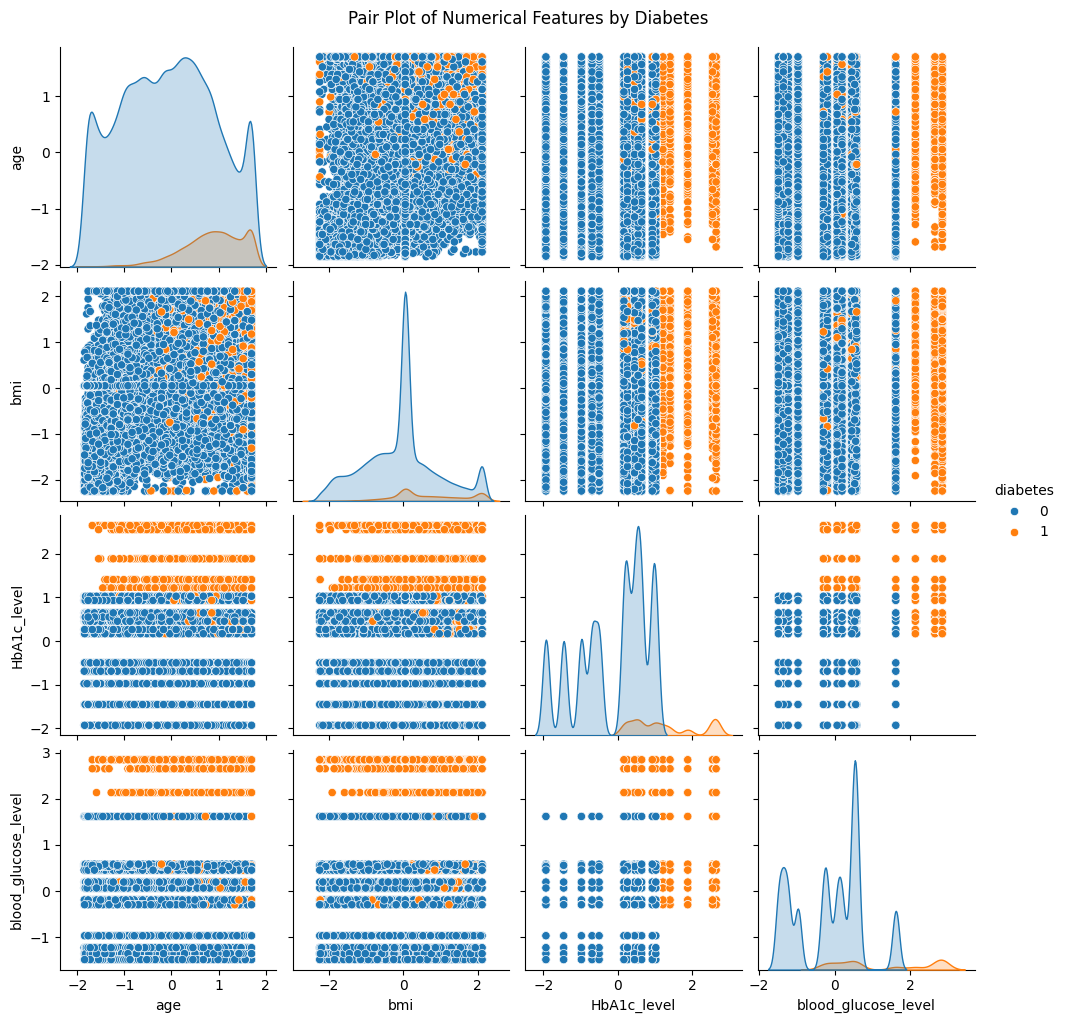

In [154]:
print("Generating Pair Plot...")
sns.pairplot(df_encoded[['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']], 
             hue='diabetes', diag_kind='kde')
plt.suptitle('Pair Plot of Numerical Features by Diabetes', y=1.02)
plt.show()

Generating Box Plots...


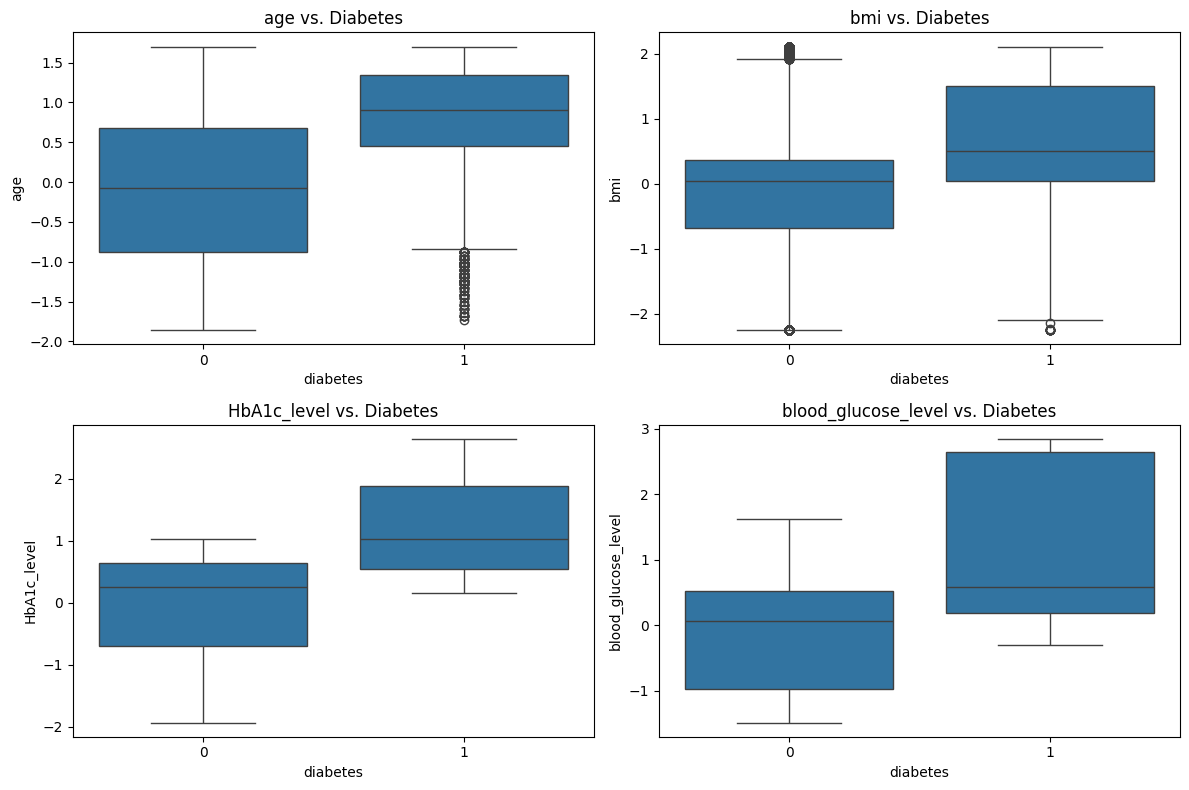

In [155]:
print("Generating Box Plots...")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
for i, col in enumerate(numerical_cols):
    sns.boxplot(x='diabetes', y=col, data=df_encoded, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col} vs. Diabetes')
plt.tight_layout()
plt.show()

Generating Count Plots...


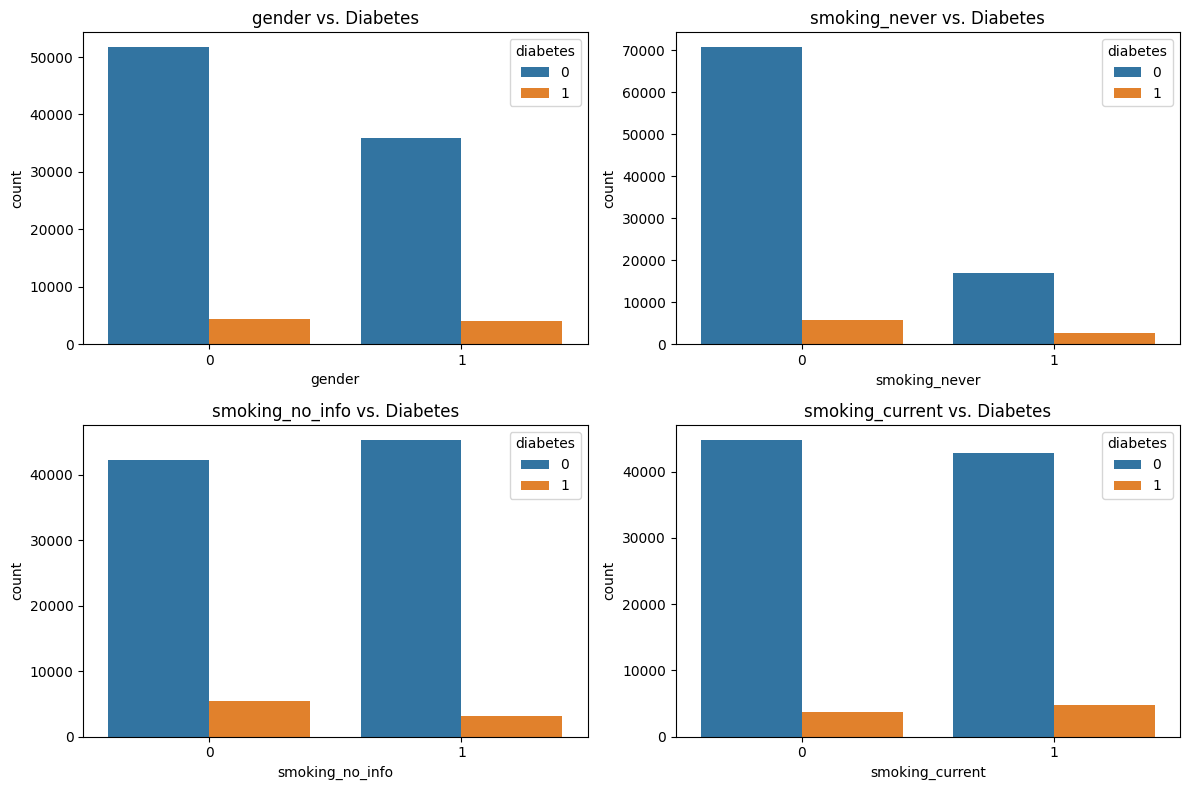

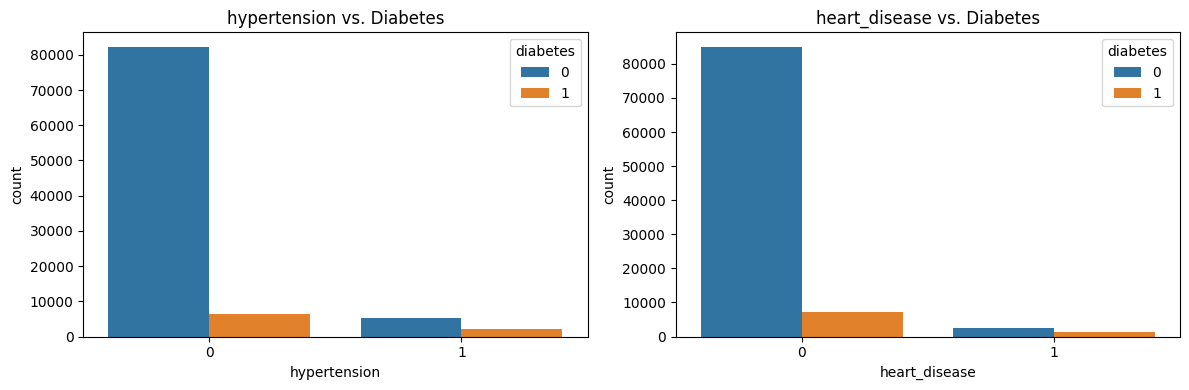

In [156]:
print("Generating Count Plots...")
categorical_cols = ['gender', 'smoking_never', 'smoking_no_info', 'smoking_current', 'hypertension', 'heart_disease']

# First figure with first 4 plots
fig1, axes1 = plt.subplots(2, 2, figsize=(12, 8))
axes1 = axes1.flatten()  # Flatten for easier indexing

for i in range(min(4, len(categorical_cols))):
    sns.countplot(x=categorical_cols[i], hue='diabetes', data=df_encoded, ax=axes1[i])
    axes1[i].set_title(f'{categorical_cols[i]} vs. Diabetes')

plt.tight_layout()
plt.show()

# Second figure with remaining plots
if len(categorical_cols) > 4:
    fig2, axes2 = plt.subplots(1, len(categorical_cols)-4, figsize=(12, 4))
    if len(categorical_cols) == 5:  # Handle case of just one subplot
        axes2 = [axes2]
        
    for i in range(4, len(categorical_cols)):
        sns.countplot(x=categorical_cols[i], hue='diabetes', data=df_encoded, ax=axes2[i-4])
        axes2[i-4].set_title(f'{categorical_cols[i]} vs. Diabetes')
    
    plt.tight_layout()
    plt.show()

In [157]:
print("Diabetes Class Distribution:")
print(df_encoded['diabetes'].value_counts())

Diabetes Class Distribution:
diabetes
0    87646
1     8482
Name: count, dtype: int64


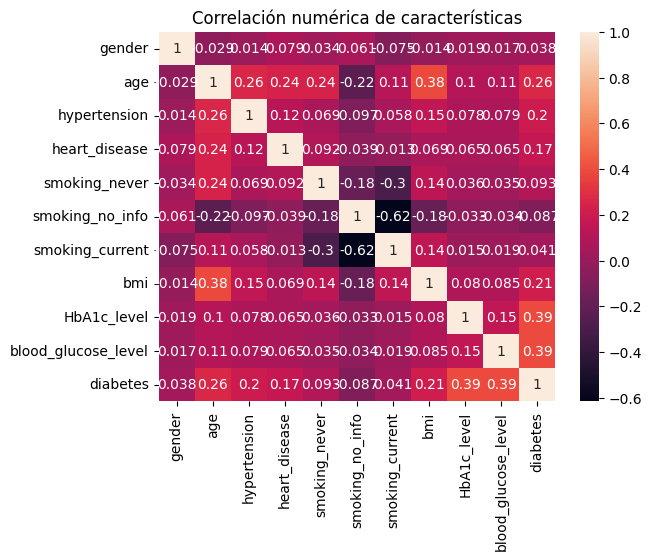

In [158]:
# Ahora vemos la correlación entre los datos

num_df = df_encoded.select_dtypes(exclude='object')
fig, ax = plt.subplots()
sns.heatmap(num_df.corr(), annot=True)
plt.title('Correlación numérica de características')
plt.show()

In [159]:
X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [160]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    }
}

In [161]:
results = []
hyperparameters = {}

for name, config in models.items():
    print(f"\nTraining {name}...")
    grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append({'Model': name, 'Accuracy': accuracy})
    hyperparameters[name] = grid.best_params_
    
    print(f"Best Parameters for {name}: {grid.best_params_}")
    print(f"Test Accuracy: {accuracy:.3f}")


Training Logistic Regression...
Best Parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Test Accuracy: 0.956

Training Random Forest...
Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 50}
Test Accuracy: 0.969

Training XGBoost...
Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Test Accuracy: 0.969


In [162]:
# prompt: number of values equals to 1 in the column diabetes
count_diabetes_1 = df[df['diabetes'] == 1]['diabetes'].count()
print(f"Number of values equal to 1 in the 'diabetes' column: {count_diabetes_1}")


Number of values equal to 1 in the 'diabetes' column: 8482


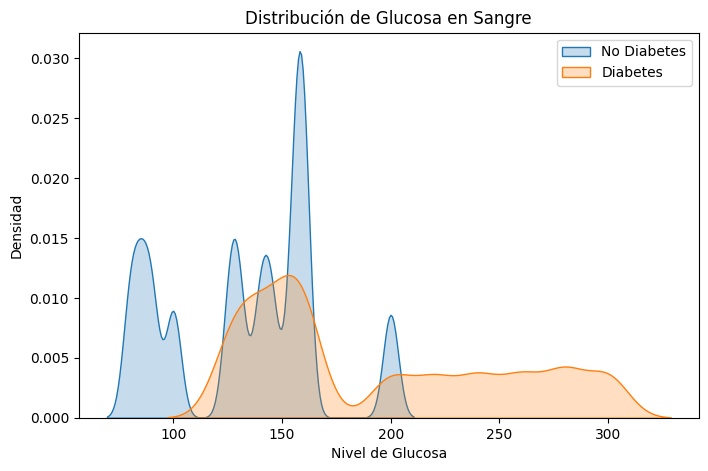

In [163]:
# Relacion entre variable dependiente y la glucosa en sangre como independiente

plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['diabetes'] == 0]['blood_glucose_level'], label='No Diabetes', fill=True)
sns.kdeplot(df[df['diabetes'] == 1]['blood_glucose_level'], label='Diabetes', fill=True)
plt.title('Distribución de Glucosa en Sangre')
plt.xlabel('Nivel de Glucosa')
plt.ylabel('Densidad')
plt.legend()
plt.show()

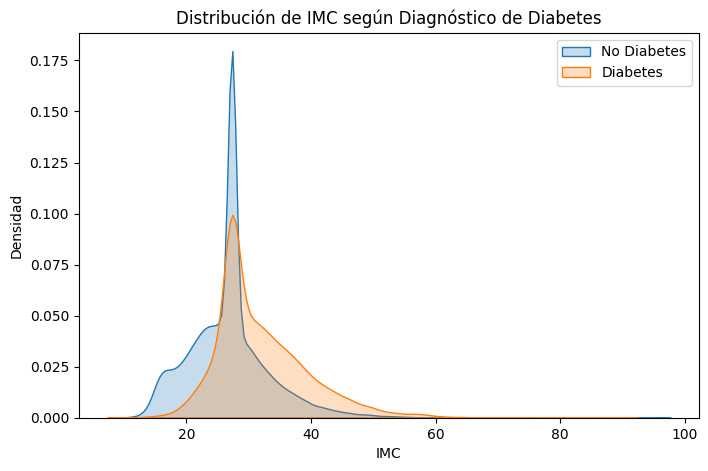

In [164]:
# Relacion entre variable dependiente e índice de masa corporal como independiente

plt.figure(figsize=(8, 5))
sns.kdeplot(df[df['diabetes'] == 0]['bmi'], label='No Diabetes', fill=True)
sns.kdeplot(df[df['diabetes'] == 1]['bmi'], label='Diabetes', fill=True)
plt.title('Distribución de IMC según Diagnóstico de Diabetes')
plt.xlabel('IMC')
plt.ylabel('Densidad')
plt.legend()
plt.show()

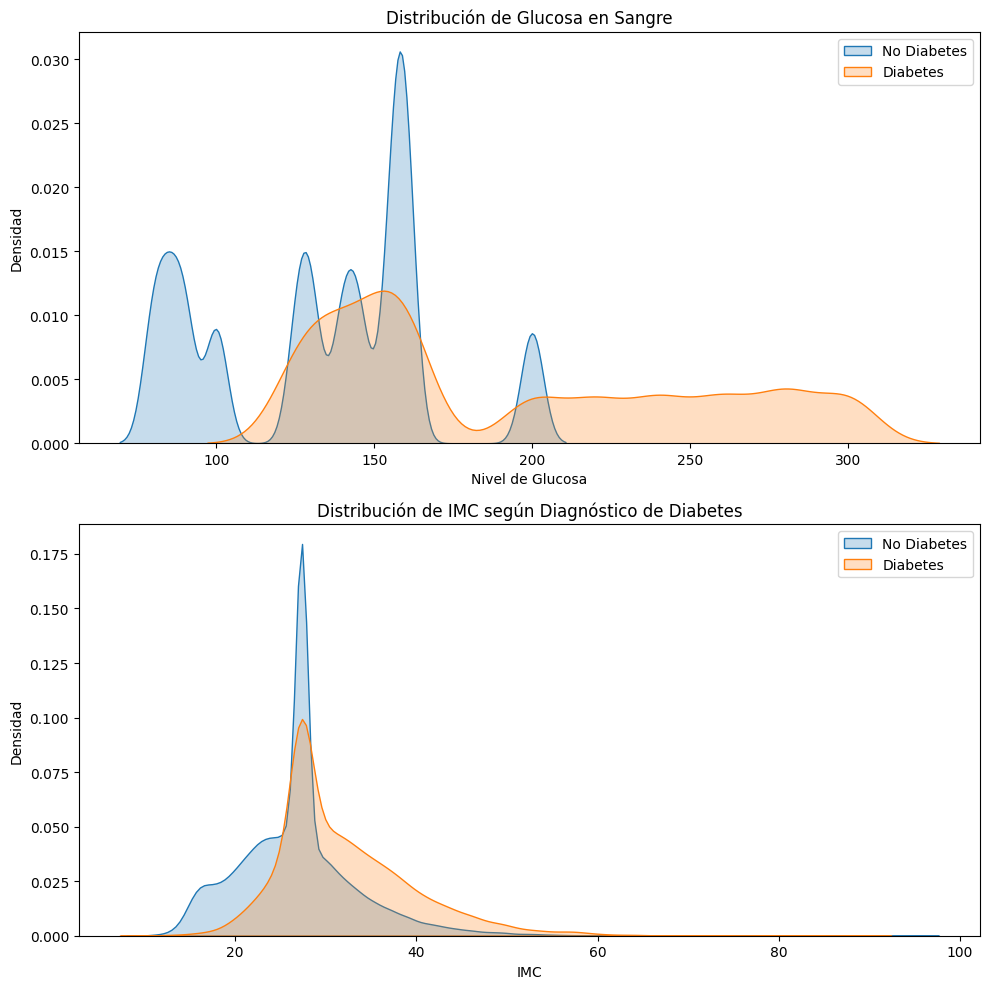

In [165]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))  # 2 filas, 1 columna

# --- Gráfico 1: Distribución de Glucosa en Sangre ---
sns.kdeplot(
    data=df[df['diabetes'] == 0]['blood_glucose_level'],
    label='No Diabetes',
    fill=True,
    ax=axs[0]
)
sns.kdeplot(
    data=df[df['diabetes'] == 1]['blood_glucose_level'],
    label='Diabetes',
    fill=True,
    ax=axs[0]
)
axs[0].set_title('Distribución de Glucosa en Sangre')
axs[0].set_xlabel('Nivel de Glucosa')
axs[0].set_ylabel('Densidad')
axs[0].legend()

# --- Gráfico 2: Distribución de IMC ---
sns.kdeplot(
    data=df[df['diabetes'] == 0]['bmi'],
    label='No Diabetes',
    fill=True,
    ax=axs[1]
)
sns.kdeplot(
    data=df[df['diabetes'] == 1]['bmi'],
    label='Diabetes',
    fill=True,
    ax=axs[1]
)
axs[1].set_title('Distribución de IMC según Diagnóstico de Diabetes')
axs[1].set_xlabel('IMC')
axs[1].set_ylabel('Densidad')
axs[1].legend()

# Ajustar espacios
plt.tight_layout()
plt.show()